<h1>Hands On Machine Learning: Chapter 3 Example</h1>

<h2>MNIST</h2>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1) # pandas DataFrame

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

<br>
<li><b>data</b>: Contains image data.</li>
<li><b>target</b>: Contains labels.</li>
<br>

In [3]:
X, y = mnist['data'].to_numpy(), mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

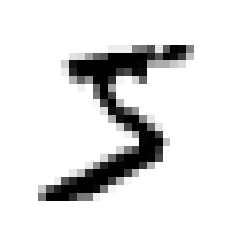

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.imshow(X[0].reshape(28, 28), cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
import numpy as np
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

<br>
<h3>1. Binary Classifier</h3>
<hr>

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([X_train[0]])

array([ True])

In [13]:
y_train_5[0]

True

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

<br>
<p>This looks quite good but the accuracy is in fact a good measure of performance. The following is why:</p>
<br>

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

<br>
<p>The all zero array shows an accuracy of 90%: This is due to skewed dataset, which means the dataset with some classes are more frequent then others. i.e. accuracy also dependent on the size of the each class.</p>
<br>

<br>
<p>Better way to evaluate the performance is to observe confusion matrix.</p>
<br>

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# returns the estimated probablity used for dicision making while performing k-fold cross validation.

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

<br>
<p>Confusion matrix:</p>
<table>
    <tr>
        <th></th>
        <th>Predicted Positive</th>
        <th>Predicted Negative</th>
    </tr>
    <tr>
        <th>Positive</th>
        <th>Number of True Positive</th>
        <th>Number of False Negative</th>
    </tr>
    <tr>
        <th>Negative</th>
        <th>Number of False Positive</th>
        <th>Number of True Negative</th>
    </tr>
</table>

<br>
<p>There are several other quantities used in evaluating the model performance.</p>
<br>
<li>$P\text{(precision)} = \frac{TP}{TP+FP}$</li>
<p>Precision measures the number of true positive instances in positively predicted instances.</p>
<li>$R\text{(recall)} = \frac{TP}{TP+FN}$</li>
<p>Recall(also called Sensitivity) measures the number of true positive instances in all positive instances.</p>
<li>$F_1\text{($F_1$ score)} = \frac{2}{\frac{1}{P} + \frac{1}{R}} = \frac{2PR}{R+P}$</li>
<p>$F_1$ score measures the harmonic mean between the precision and recall. It shows high score when the precision and recall have similar values.</p>
<br>

In [19]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

0.8370879772350012 0.6511713705958311


In [20]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

<br>
<p>In most cases, the precision-recall tradeoff is observed while moving the <b>decision threshold</b>(one of the hyperparameter). This is due to the ambiguity created by noise of the data. If we make the ML algorithm predict the true instances more to be true(increasing precision), it will predict more false instances to be false because of the noise in the data(decreasing recall). This precision-recall tradeoff is more specified on <b>ROC(receiver operating characteristic) curve.</b></p>
<br>

<br>
<p>ROC curve is the graph of two values,</p>
<li>$TPR\text{(True Positive Rate)} = \frac{TP}{TP+FN} = \frac{TP}{Positives} = R$</li>
<li>$FPR\text{(False Positive Rate)} = \frac{FP}{FP+TN} = \frac{FP}{Negatives} = 1- S\text{(specificity)}$</li>
<br>
<p>These two values shows the precision-recall tradeoff more clearly because the denominator is fixed unlike the precision(the denominator of the precision changes).</p>
<br>

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

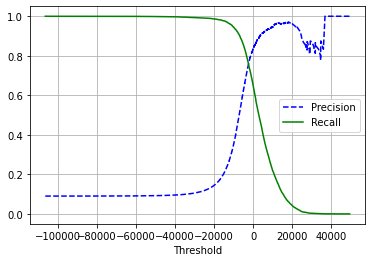

In [22]:
# Precision-Recall tradeoff
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    ax = plt.gca()
    ax.set_xlabel('Threshold')
    plt.grid(True)
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

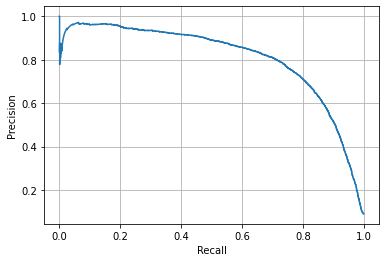

In [23]:
# Precision-Recall curve
def plot_precision_recall_curve(recalls, precisions):
    plt.plot(recalls, precisions)
    ax = plt.gca()
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    plt.grid(True)

plot_precision_recall_curve(recalls, precisions)

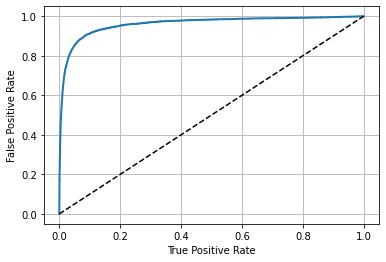

In [24]:
# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    ax = plt.gca()
    ax.set_xlabel('True Positive Rate')
    ax.set_ylabel('False Positive Rate')
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()

<br>
<p>The perfect classifier will show the rectangular curve. The perfectly random classifier will show the line from $(0,\ 0)$ to $(1,\ 1)$.</p>
<p>From this fact we can come up with the other measure for the model performance:</p>
$$AUC\text{(area under curve)} =
\begin{cases}
1 && \text{Perfect Classifier} \\
\frac{1}{2} && \text{Random Classifier} \\
\end{cases}
$$
<br>

In [26]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [27]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1] # probability of the positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

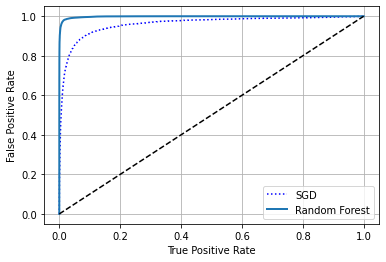

In [28]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend()
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

<br>
<p>We can check that the random forest method predicts more better.</p>
<br>

<br>
<h3>2. Multiclass Classification</h3>
<hr>

<br>
<p>Some algorithms are capable of the multiclass classification, but some are not.</p>
<p>There are two strategies to use algorithms which performs only for a binary classification in the situation of the multiclass classification.</p>
<br>
<li><b>One-versus-All(OvA)</b> strategy: Run the binary classifier for each class.</li>
<li><b>One-versus-One(OvO)</b> strategy: Run the binary classifier for each pair of classes.</li>
<br>
<p>Some algorithms such as support vector machine which requires large resources when training set size is big OvO strategy is preferred.</p>
<br>

In [31]:
# Scikit-learn will automatically detect the data and performs OvA multiclass classification.(except for SVM1
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [34]:
n = np.random.randint(len(X_train))
print(sgd_clf.predict([X_train[n]]), y_train[n])

[3] 3


<br>
<h3>3. Error Analysis</h3>
<hr>

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

[[5635    0   61   10   16   50   46    7   66   32]
 [   3 6393   95   21   16   47   15   27  109   16]
 [  72   56 5174   89   69   39  163   66  212   18]
 [  58   32  217 4941   23  441   32   56  216  115]
 [  11   26   46    6 5298   26   73   32   87  237]
 [  68   23   58  150   83 4606  174   26  152   81]
 [  40   13   56    6   22  113 5625    5   36    2]
 [  23   24  103   36  124   40   10 5228   75  602]
 [  40  101  158  122   49  457   77   35 4666  146]
 [  33   18   66   83  515  127    4  485  166 4452]]


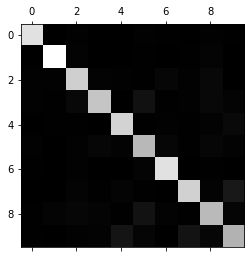

In [41]:
# visualize confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

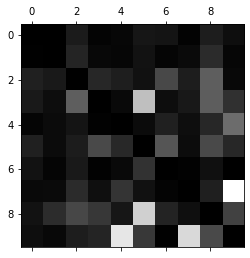

In [42]:
# Show rates by the predicted label numbers(row sum)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0) # Replace diagonal terms to 0, because this is not the errors.
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()